In [1]:
import os
import numpy as np
from tqdm import tqdm
import pywt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

In [2]:
def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data


def read_labels_ucihar(filename):
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Dataset address

In [3]:
folder = '/content/drive/MyDrive/data/HAR/'

train_folder = folder + 'train/Inertial Signals/'
test_folder = folder + 'test/Inertial Signals/'

labelfile_train = folder + 'train/y_train.txt'
labelfile_test = folder + 'test/y_test.txt'

train_signals, test_signals = [], []

for input_file in tqdm(os.listdir(train_folder)):
    signal = read_signals_ucihar(train_folder + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in tqdm(os.listdir(test_folder)):
    signal = read_signals_ucihar(test_folder + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels_ucihar(labelfile_train)
test_labels = read_labels_ucihar(labelfile_test)

100%|██████████| 9/9 [00:01<00:00,  7.60it/s]


In [4]:
scales = range(1,128)
waveletname = 'morl'
train_size = 5000
test_size= 500

train_data_cwt = np.ndarray(shape=(train_size, 127, 127, 9))

for ii in tqdm(range(train_size)):
    for jj in range(9):
        signal = train_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        train_data_cwt[ii, :, :, jj] = coeff_

test_data_cwt = np.ndarray(shape=(test_size, 127, 127, 9))
for ii in tqdm(range(test_size)):
    for jj in range(9):
        signal = test_signals[ii, :, jj]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:127]
        test_data_cwt[ii, :, :, jj] = coeff_

uci_har_labels_train = list(map(lambda x: int(x) - 1, train_labels))
uci_har_labels_test = list(map(lambda x: int(x) - 1, test_labels))

100%|██████████| 500/500 [00:38<00:00, 13.08it/s]


In [5]:
class Net(nn.Module):
    def __init__(self, img_z, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(img_z, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 28 * 28, 1000)
        self.fc2 = nn.Linear(1000, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [6]:
# data parameters
img_x, img_y, img_z = 127, 127, 9
num_classes = 7
batch_size = 16
n_epochs = 10
learning_rate = 0.00001
weight_decay = 1e-4
m_seed = 999

torch.manual_seed(m_seed)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [7]:
x_train = train_data_cwt
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
y_train = list(uci_har_labels_train[:train_size])

x_test = test_data_cwt
x_test = np.transpose(np.array(x_test), (0, 3, 1, 2))
y_test = list(uci_har_labels_test[:test_size])

x_train = torch.tensor(x_train.astype('float32'), device=device)
x_test = torch.tensor(x_test.astype('float32'), device=device)

# convert labels to one-hot encoding
y_train = torch.tensor(np.eye(num_classes)[y_train], device=device)
y_test = torch.tensor(np.eye(num_classes)[y_test],device=device)

# create data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = Net(img_z, num_classes).to(device)
print(model)

Net(
  (conv1): Conv2d(9, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
)


In [8]:
# set loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader))
scaler = torch.cuda.amp.GradScaler()  # Initialize the GradScaler

In [9]:
loss_list = []
lr_list = []
# training loop
for epoch in tqdm(range(n_epochs)):
    for inputs, labels in train_loader:
        optimizer.zero_grad()


        with torch.cuda.amp.autocast():
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, torch.max(labels, 1)[1])  # Compute the loss

        scaler.scale(loss).backward()  # Scale the loss and perform backward pass

        scaler.step(optimizer)  # Update model parameters
        scaler.update()  # Update the scale factor for the next iteration
        scheduler.step()

        loss_list.append(loss.item())
        lr_list.append(optimizer.param_groups[0]["lr"])

100%|██████████| 10/10 [01:37<00:00,  9.78s/it]


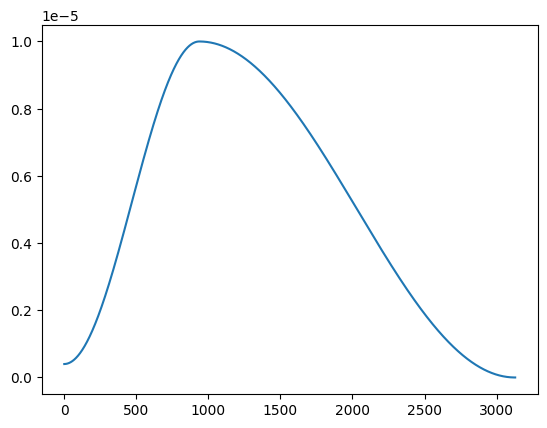

In [10]:
plt.plot(lr_list)

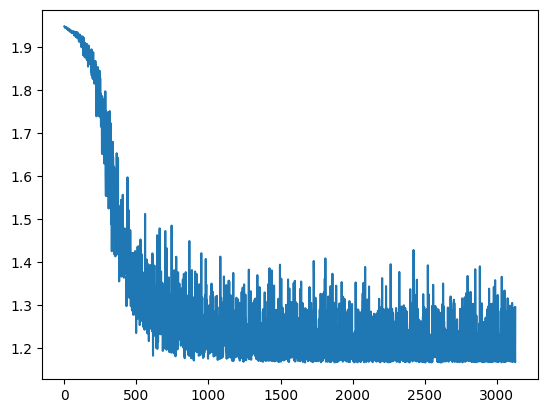

In [11]:
plt.plot(loss_list)

In [12]:
# model evaluation
def evaluate(data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, true_labels = torch.max(labels.data, 1)
            total += true_labels.size(0)
            correct += (predicted == true_labels).sum().item()

    print('Accuracy: {:.2f}%'.format(100 * correct / total))

print('Train: ')
evaluate(train_loader)
print('Test: ')
evaluate(test_loader)

Train: 
Accuracy: 95.78%
Test: 
Accuracy: 81.40%
